# MC thesis studies. 

**Idea**: Keep this ruthlessly organized. Each section is targeted at a specific thesis plot/study. No more no less. Start with the simplest things first. 

In [1]:
%load_ext autoreload

In [85]:
%autoreload 2
import sys
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import seaborn as sns
from datetime import datetime
import numpy as np
import uproot4
from lmfit import minimize, Parameters, fit_report
from scipy import integrate
from pathlib import Path

# Jupyter Lab imports.
import ipywidgets as widgets
from ipywidgets import interact, interact_manual, fixed

# Path to local imports.
sys.path.append("/home/drew/He6CRES/rocks_analysis_pipeline/")
from results import ExperimentResults
from rocks_utility import he6cres_db_query

# Path to local imports.
sys.path.append("/home/drew/He6CRES/he6-cres-spec-sims/")

# Local imports.
import he6_cres_spec_sims.spec_tools.spec_calc.spec_calc as sc
import he6_cres_spec_sims.experiment as exp
import he6_cres_spec_sims.spec_tools.beta_source.beta_spectrum as bs

# Local imports for plotting ratios and such. 
import analysis_functions.ratio_experiment as re
import analysis_functions.ratio_prediction as rp
import analysis_functions.plotting_methods as pm
import mc_functions.simple_mc as mc
import mc_functions.const_prop_vs_counts as cpc
import mc_functions.const_prop_vs_mon as cpm
import mc_functions.B_sensitivity as btest
import mc_functions.mon_drift_sensitivity as montest
import mc_functions.wall_effect as we
import mc_functions.energy_domain as ed
import mc_functions.from_below as fb

# Plot font size
plt.rcParams.update({'font.size': 20})

## MC1, Thesis Section: Ratio measurement sensitivity to \littleb

**Idea**: Used to give a simple deltab \sim Const/rootN. 

**Notes**: 

* The total number of monitor counts does matter for a given field. Look up what it is currently. This study could quote a statistical error with that number as well (C/rootN). 

**To Dos**: 

* Add in the residuals to the plots like we have in paper-01.

### MC1, step 0: Illustrate it's working.

[[Variables]]
    C:  1.05886225 +/- 0.01895523 (1.79%) (init = 1)
    b:  0.13946738 +/- 0.12304127 (88.22%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(C, b) = 0.248


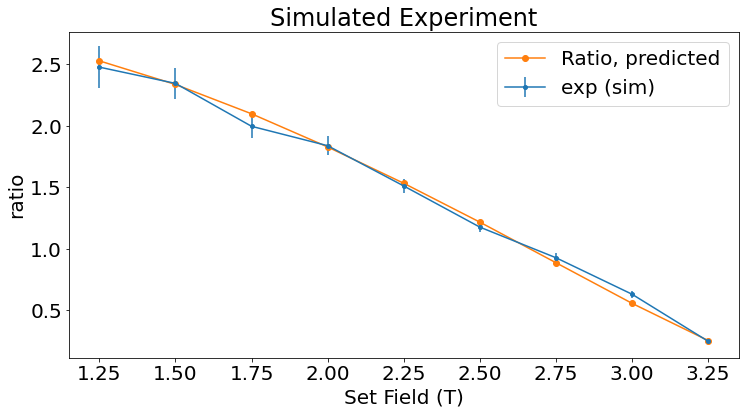

In [9]:
# Select set fields. 
set_fields = np.arange(1.25,3.5,.25)
# Freq BW.
freq_BW = np.array([19.0e9 ,  19.1e9])
# Tile freq_BW.
freq_BWs = np.tile(freq_BW, (len(set_fields), 1))

# C, relationship between he and ne monitor.
C_exp = np.random.uniform(.5,1.5)

# Number of counts: 
N = 10**4
# monitor rate tot: 
mon = 10**8
# Set little b.
b = 0

# Simulate simple experiment.
ratio_exp, spectra_ne_exp, spectra_he_exp = mc.simple_MC(set_fields, 
                                                         freq_BWs, 
                                                         C_exp, 
                                                         b, 
                                                         counts_per_isotope = N, 
                                                         monitor_rate = mon,
                                                         counts_pois = True, 
                                                         mon_pois = True)

ratio_pred = rp.AUC_expectation(set_fields, freq_BWs, b = b, plot = False)

# Conduct fit. 
my_pars = Parameters()
my_pars.add('C', value=1, min=0, max = 10, vary =True)
my_pars.add('b', value=.1, min=-10, max = 10, vary =True)

result = minimize(mc.objfunc_chisq, my_pars, args = (freq_BWs, set_fields, ratio_exp, b))

# Fit report.
print(fit_report(result.params))

# Plot results.
fig0, ax0 = plt.subplots(figsize=(12,6))

C = result.params["C"].value

ratio_exp_cp = ratio_exp.copy()
ratio_exp_cp["Ratio"] = C*ratio_exp_cp["Ratio"]
ratio_exp_cp["sRatio"] = C*ratio_exp_cp["sRatio"]

pm.plot_experimental_ratio(ratio_exp_cp, ax0, label= f"exp (sim)")
pm.plot_predicted_ratio(ratio_pred, ax0)

# ax0.set_yscale("log")
ax0.set_ylabel('ratio')
ax0.set_xlabel('Set Field (T)')
ax0.set_title(f"Simulated Experiment")
ax0.legend()
plt.show()

### MC1, step 1: Dependence on counts_per_isotope

**Notes**:
* I'm using .75 - 3.25 here as that's our ultimate goal.
* I'm not poisson varying the monitor. 
* Building these into modules for ease. 

In [8]:
# Select set fields. 
set_fields = np.arange(.75,3.5,.25)
# Freq BW.
freq_BW = np.array([18.0e9 ,  19.1e9])

b_uncert = cpc.run_N_const_prop_test(set_fields, freq_BW, exp_max = 13, trial_max = 64 )
cpc.plot_N_const_prop_test(b_uncert)

N = 10**3, trial = 0
/home/drew/He6CRES/rocks_analysis_notebooks
/home/drew/He6CRES/he6-cres-spec-sims/he6_cres_spec_sims/spec_tools/beta_source
True
/home/drew/He6CRES/rocks_analysis_notebooks
/home/drew/He6CRES/he6-cres-spec-sims/he6_cres_spec_sims/spec_tools/beta_source
True
/home/drew/He6CRES/rocks_analysis_notebooks
/home/drew/He6CRES/he6-cres-spec-sims/he6_cres_spec_sims/spec_tools/beta_source
True
/home/drew/He6CRES/rocks_analysis_notebooks
/home/drew/He6CRES/he6-cres-spec-sims/he6_cres_spec_sims/spec_tools/beta_source
True
/home/drew/He6CRES/rocks_analysis_notebooks
/home/drew/He6CRES/he6-cres-spec-sims/he6_cres_spec_sims/spec_tools/beta_source
True
/home/drew/He6CRES/rocks_analysis_notebooks
/home/drew/He6CRES/he6-cres-spec-sims/he6_cres_spec_sims/spec_tools/beta_source
True
/home/drew/He6CRES/rocks_analysis_notebooks
/home/drew/He6CRES/he6-cres-spec-sims/he6_cres_spec_sims/spec_tools/beta_source
True
/home/drew/He6CRES/rocks_analysis_notebooks
/home/drew/He6CRES/he6-cres-spec

KeyboardInterrupt: 

### MC1, step 2: Dependence on monitor counts per field

**Notes**:
* I'm using .75 - 3.25 here as that's our ultimate goal.
* I'm not poisson varying the counts. 
* Building these into modules for ease. 

mon counts per field = 10**3, trial = 0
mon counts per field = 10**3, trial = 1
mon counts per field = 10**3, trial = 2
mon counts per field = 10**3, trial = 3
mon counts per field = 10**3, trial = 4
mon counts per field = 10**3, trial = 5
mon counts per field = 10**3, trial = 6
mon counts per field = 10**3, trial = 7
mon counts per field = 10**3, trial = 8
mon counts per field = 10**3, trial = 9
mon counts per field = 10**3, trial = 10
mon counts per field = 10**3, trial = 11
mon counts per field = 10**3, trial = 12
mon counts per field = 10**3, trial = 13
mon counts per field = 10**3, trial = 14
mon counts per field = 10**3, trial = 15
mon counts per field = 10**3, trial = 16
mon counts per field = 10**3, trial = 17
mon counts per field = 10**3, trial = 18
mon counts per field = 10**3, trial = 19
mon counts per field = 10**3, trial = 20
mon counts per field = 10**3, trial = 21
mon counts per field = 10**3, trial = 22
mon counts per field = 10**3, trial = 23
mon counts per field = 10*

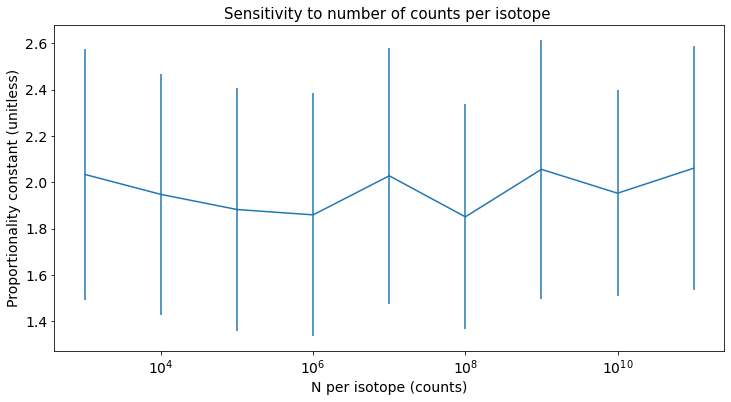

In [104]:
# Select set fields. 
set_fields = np.arange(.75,3.5,.25)
# Freq BW.
freq_BW = np.array([18.0e9 ,  19.1e9])

b_uncert = cpm.run_mon_const_prop_test(set_fields, freq_BW, exp_max = 12, trial_max = 64 )
cpm.plot_mon_const_prop_test(b_uncert)

## MC2, Thesis Section: \littleb sensitivity to B (mismatch and determination)

**Idea**: 

**Notes**: 

* So here we want to not have any statistical error, we want to just see what the effect on our littleb determination is as a function of a mismatch in fields

**To Dos**: 

* Start with B_sensitivity, try to make it work with either random set_fields or an offset. I think we're after a db/dB or something but not sure exactly... Do some exploring then talk with Alejandro. 

**Questions**:

* How do we actually get the desired thing we want here? a dB/

### MC2, step 0: Illustrate it's working.

[[Variables]]
    C:  0.91132994 +/- 9.7288e-04 (0.11%) (init = 1)
    b: -0.01213243 +/- 0.00552901 (45.57%) (init = 0.1)


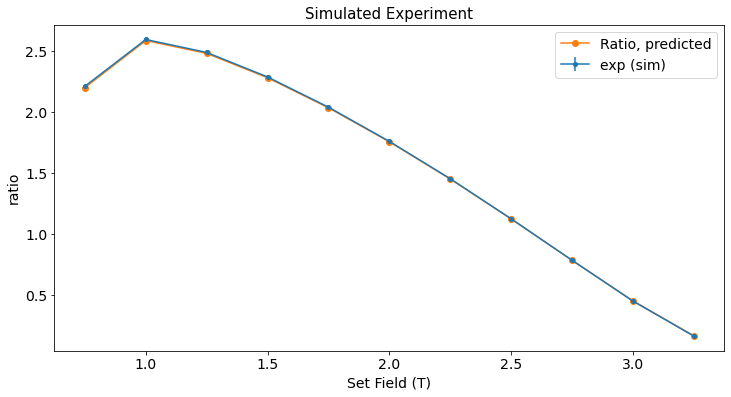

In [121]:
# Select set fields. 
set_fields_niave = np.arange(.75,3.5,.25)
seed = 1234
rng = np.random.default_rng(seed=seed)
# Add in some uncertainty in the field that's different for ne and he. 
field_error = 10**-4
field_offset = 10**-3
set_fields_ne = rng.normal(set_fields+set_fields*field_offset, set_fields*field_error)
set_fields_he = rng.normal(set_fields, set_fields*field_error)

# Freq BW.
freq_BW = np.array([18.0e9 ,  19.1e9])
# Tile freq_BW.
freq_BWs = np.tile(freq_BW, (len(set_fields), 1))

# C, relationship between he and ne monitor.
C_exp = np.random.uniform(.5,1.5)

# Number of counts: 
N = 10**10
# monitor rate tot: 
mon = 10**10
# Set little b.
b = 0

# Simulate simple experiment.
ratio_exp, spectra_ne_exp, spectra_he_exp = btest.field_spread_MC(set_fields_ne,
                                                                  set_fields_he,
                                                                  set_fields_niave,
                                                                 freq_BWs, 
                                                                 C_exp, 
                                                                 b, 
                                                                 counts_per_isotope = N, 
                                                                 monitor_rate = mon,
                                                                 counts_pois = True, 
                                                                 mon_pois = True)

ratio_pred = rp.AUC_expectation(set_fields, freq_BWs, b = b, plot = False)

# Conduct fit. 
my_pars = Parameters()
my_pars.add('C', value=1, min=0, max = 10, vary =True)
my_pars.add('b', value=.1, min=-10, max = 10, vary =True)

result = minimize(mc.objfunc_chisq, my_pars, args = (freq_BWs, set_fields, ratio_exp, b))

# Fit report.
print(fit_report(result.params))

# Plot results.
fig0, ax0 = plt.subplots(figsize=(12,6))

C = result.params["C"].value

ratio_exp_cp = ratio_exp.copy()
ratio_exp_cp["Ratio"] = C*ratio_exp_cp["Ratio"]
ratio_exp_cp["sRatio"] = C*ratio_exp_cp["sRatio"]

pm.plot_experimental_ratio(ratio_exp_cp, ax0, label= f"exp (sim)")
pm.plot_predicted_ratio(ratio_pred, ax0)

# ax0.set_yscale("log")
ax0.set_ylabel('ratio')
ax0.set_xlabel('Set Field (T)')
ax0.set_title(f"Simulated Experiment")
ax0.legend()
plt.show()

### MC2, step 1: Dependence on counts_per_isotope

In [148]:
field_errs = np.linspace(10**-5, 2*10**-2,10)
field_offsets = np.linspace(10**-5, 2*10**-2,10)

field_err_test, field_offset_test = btest.run_B_sensitivity_test(field_errs, field_offsets, trial_max = 20 )

display(field_err_test)
display(field_offset_test)

Field err: 1e-05, trial: 0
Field err: 1e-05, trial: 1
Field err: 1e-05, trial: 2
Field err: 1e-05, trial: 3
Field err: 1e-05, trial: 4
Field err: 1e-05, trial: 5
Field err: 1e-05, trial: 6
Field err: 1e-05, trial: 7
Field err: 1e-05, trial: 8
Field err: 1e-05, trial: 9
Field err: 1e-05, trial: 10
Field err: 1e-05, trial: 11
Field err: 1e-05, trial: 12
Field err: 1e-05, trial: 13
Field err: 1e-05, trial: 14
Field err: 1e-05, trial: 15
Field err: 1e-05, trial: 16
Field err: 1e-05, trial: 17
Field err: 1e-05, trial: 18
Field err: 1e-05, trial: 19
Field err: 0.0022311111111111112, trial: 0
Field err: 0.0022311111111111112, trial: 1
Field err: 0.0022311111111111112, trial: 2
Field err: 0.0022311111111111112, trial: 3
Field err: 0.0022311111111111112, trial: 4
Field err: 0.0022311111111111112, trial: 5
Field err: 0.0022311111111111112, trial: 6
Field err: 0.0022311111111111112, trial: 7
Field err: 0.0022311111111111112, trial: 8
Field err: 0.0022311111111111112, trial: 9
Field err: 0.0022311

KeyboardInterrupt: 

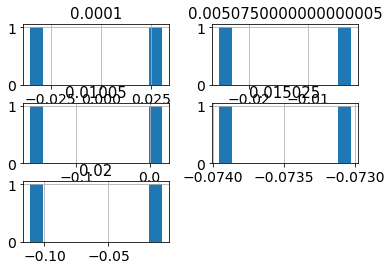

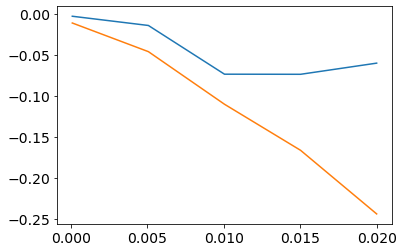

In [146]:
field_err_test.hist(bins = 10)
plt.show()

plt.plot(field_err_test.mean())
plt.plot(field_offset_test.mean())

## MC3, Thesis Section: Sensitivity to monitor instability

**Idea**: 

**Notes**: 

* So here we want to not have any statistical error, we want to just see what the effect on our littleb determination is as a function of a linear drift in the monitor stability. 
* A key point here is that if both the ne and he experiments drift together then there is no issue at all. So let's give both a drift metric seperately.  

**To Dos**: 

* Start  

**Questions**:

### MC3, step 0: Illustrate it's working.

In [ ]:
# Select set fields. 
set_fields = np.arange(.75,3.5,.25)
seed = 1234
rng = np.random.default_rng(seed=seed)

# Freq BW.
freq_BW = np.array([18.0e9 ,  19.1e9])
# Tile freq_BW.
freq_BWs = np.tile(freq_BW, (len(set_fields), 1))

# C, relationship between he and ne monitor.
C_exp = rng.uniform(.5,1.5)

# Number of counts: 
N = 10**10
# monitor rate tot: 
mon = 10**10
# Set little b.
b = 0
mon_drift_ne = -.1
mon_drift_he = .1

# Simulate simple experiment.
ratio_exp, spectra_ne_exp, spectra_he_exp = montest.mon_drift_MC(set_fields,
                                                                 freq_BWs, 
                                                                 C_exp, 
                                                                 b, 
                                                                 mon_drift_ne = mon_drift_ne,
                                                                 mon_drift_he = mon_drift_he,
                                                                 counts_per_isotope = N, 
                                                                 monitor_rate = mon,
                                                                 counts_pois = True, 
                                                                 mon_pois = False)

display(spectra_ne_exp)
display(spectra_he_exp)
spread_ne = (spectra_ne_exp["tot_monitor_rate"].iloc[-1] - spectra_ne_exp["tot_monitor_rate"].iloc[0]) / spectra_ne_exp["tot_monitor_rate"].iloc[0]
spread_he = (spectra_he_exp["tot_monitor_rate"].iloc[-1] - spectra_he_exp["tot_monitor_rate"].iloc[0]) / spectra_he_exp["tot_monitor_rate"].iloc[0]
print( spread_ne, spread_he)

In [ ]:
ratio_pred = rp.AUC_expectation(set_fields, freq_BWs, b = b, plot = False)

# Conduct fit. 
my_pars = Parameters()
my_pars.add('C', value=1, min=0, max = 10, vary =True)
my_pars.add('b', value=.1, min=-10, max = 10, vary =True)

result = minimize(mc.objfunc_chisq, my_pars, args = (freq_BWs, set_fields, ratio_exp, b))

# Fit report.
print(fit_report(result.params))

# Plot results.
fig0, ax0 = plt.subplots(figsize=(12,6))

C = result.params["C"].value

ratio_exp_cp = ratio_exp.copy()
ratio_exp_cp["Ratio"] = C*ratio_exp_cp["Ratio"]
ratio_exp_cp["sRatio"] = C*ratio_exp_cp["sRatio"]

pm.plot_experimental_ratio(ratio_exp_cp, ax0, label= f"exp (sim)")
pm.plot_predicted_ratio(ratio_pred, ax0)

# ax0.set_yscale("log")
ax0.set_ylabel('ratio')
ax0.set_xlabel('Set Field (T)')
ax0.set_title(f"Simulated Experiment")
ax0.legend()
plt.show()

### MC3, step 1: Run the full test.

In [23]:
mon_drifts = 10**np.arange(-5,0,1, dtype=float)
print(mon_drifts)
mon_test_df = montest.run_mon_sensitivity_test( mon_drifts, trial_max = 2)

[1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]
Monitor drift: 1e-05, trial: 0
Monitor drift: 1e-05, trial: 1
Monitor drift: 0.0001, trial: 0
Monitor drift: 0.0001, trial: 1
Monitor drift: 0.001, trial: 0
Monitor drift: 0.001, trial: 1
Monitor drift: 0.01, trial: 0
Monitor drift: 0.01, trial: 1
Monitor drift: 0.1, trial: 0
Monitor drift: 0.1, trial: 1


In [24]:
mon_test_df

,0.00001,0.00010,0.00100,0.01000,0.10000
0,0.000028,0.000057,-0.001137,-0.011161,-0.104341
1,0.000036,-0.000005,-0.001150,-0.011128,-0.104459


## MC4, Thesis Section: Wall effect.

**Idea**: 

*  

**Notes**: 

* Start here, build what you have in the other nb into here (into mudules you can use for MC5). 
* Illustrate how chunking things up here reduces the size of the systematics/corrections?

**To Dos**: 

*  

**Questions**:

### MC4, step 0: Illustrate it's working.

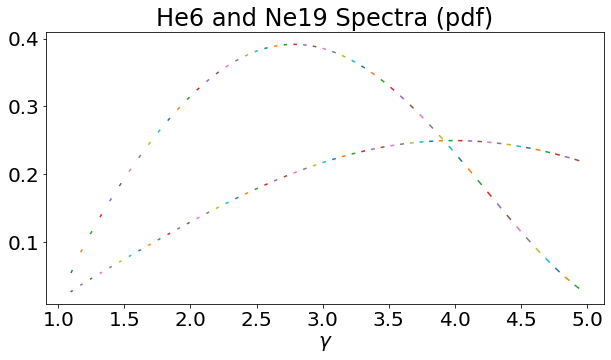

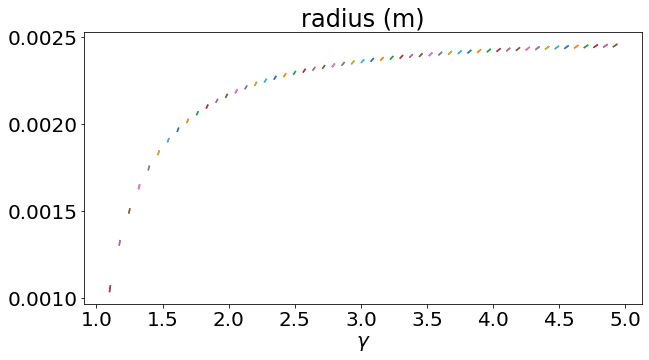

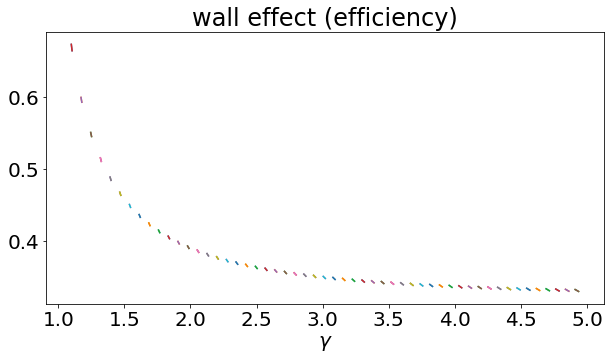

Text(0.5, 1.0, '$(R_{wall} / R_0) - 1 $ ')

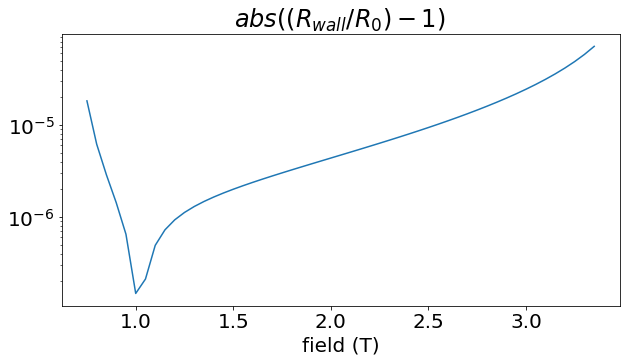

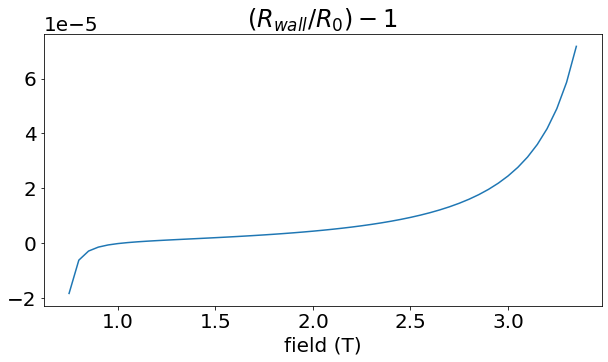

In [30]:
# Select set fields. 
set_fields = np.arange(.75,3.4,.05)

# Freq BW.
freq_BW = np.array([19.0e9 ,  19.1e9])
freq_BWs = np.tile(freq_BW, (len(set_fields), 1))

ratio_wall = we.AUC_expectation_we(set_fields, freq_BWs, b = 0, plot = True, wall_effect = True)  

ratio_0 = we.AUC_expectation_we(set_fields, freq_BWs, b = 0, plot = False, wall_effect = False)  

wall_effect = (ratio_wall/ratio_0 - 1)["Ratio"]

f0, ax0 = plt.subplots(1, figsize=(10,5))
wall_effect.abs().plot(ax = ax0)

ax0.set_yscale("log")
ax0.set_xlabel(r"field (T)")
ax0.set_title(r"$abs((R_{wall} / R_0) - 1 )$ ")

f1, ax1 = plt.subplots(1, figsize=(10,5))
wall_effect.plot(ax = ax1)

ax1.set_yscale("linear")
ax1.set_xlabel(r"field (T)")
ax1.set_title(r"$(R_{wall} / R_0) - 1 $ ")



## MC5, Thesis Section: An alternate way to present the data

**Idea**: 

* We want to illustrate that we can measure the efficiency with one isotope and then use that to plot the rate as a function of field for the other isotope. 

**Notes**: 

*   

**To Dos**: 

* When I calculate the stderr of the ratio I should include the error from the beta monitor. This is crucial. 


**Questions**:

* Is the different objective function actually accomplishing something different or not?
    * Yes, they are the same. Which makes sense because the normalization C gives the ratio in units of AUC_ne/AUC_he. Doh. Took me the long way around to figure it out but actually much nicer to present this way. Ok. Rehashing this to make it cleaner. 


### MC5, step 0: Illustrate it's working.
* This isn't working and I don't know why exactly... OHHHHHH. Wait no I'm not sure. Thought I dealt with the efficiencies wrong but now I don't think so. Oh well. 

#### Step 0: Simulate the counts.

#### Step 1: Validate that the wall effect is making a difference.

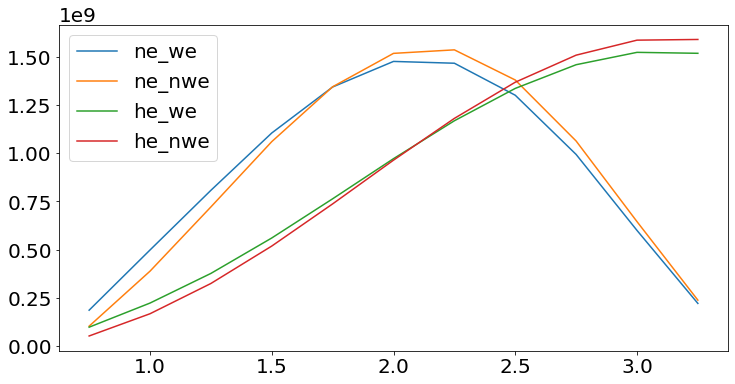

In [3]:
# Select set fields. 
set_fields = np.arange(.75,3.5,.25)

# Freq BW.
freq_BW = np.array([18.0e9 ,  19.1e9])
freq_BWs = np.tile(freq_BW, (len(set_fields), 1))

C_exp = .75
b=0

spectra_ne_nwe, spectra_he_nwe = we.we_simple_MC(set_fields, 
              freq_BWs, 
              C_exp, 
              b, 
              counts_per_isotope = 10**10, 
              monitor_rate = 10**12,                                  
              counts_pois = True,                           
              mon_pois = True,
              wall_effect = False)

spectra_ne_we, spectra_he_we = we.we_simple_MC(set_fields, 
              freq_BWs, 
              C_exp, 
              b, 
              counts_per_isotope = 10**10, 
              monitor_rate = 10**12,                                  
              counts_pois = True,                           
              mon_pois = True,
              wall_effect = True)

# Plot results.
fig0, ax0 = plt.subplots(figsize=(12,6))

plt.plot(spectra_ne_we.index, spectra_ne_we.event_count, label = "ne_we")
plt.plot(spectra_ne_nwe.index, spectra_ne_nwe.event_count, label = "ne_nwe")

plt.plot(spectra_he_we.index, spectra_he_we.event_count, label = "he_we")
plt.plot(spectra_he_nwe.index, spectra_he_nwe.event_count, label = "he_nwe")
ax0.legend()

#### Step 2: Now calculate the efficiency.

* Key here is that the experimental ratio times the He6 spectrum should give you something proportional to the SM ne19 spectrum

In [4]:
# Build the experimental ratio.
ratio_exp = re.build_ratio_altnorm(spectra_ne_we, spectra_he_we)

display(ratio_exp)

,Ne19,He6,Ratio,sRatio
set_field,,,,
0.75,0.000248,0.000098,2.531432,0.000316
1.00,0.000664,0.000223,2.978729,0.000240
1.25,0.001077,0.000377,2.858493,0.000178
1.50,0.001473,0.000561,2.628653,0.000136
1.75,0.001792,0.000764,2.345600,0.000106
2.00,0.001968,0.000972,2.025255,0.000084
2.25,0.001956,0.001169,1.673824,0.000066
2.50,0.001735,0.001336,1.298059,0.000051
2.75,0.001325,0.001459,0.908136,0.000037


In [7]:
# Conduct fit. 
my_pars = Parameters()
my_pars.add('C', value=1, min=-100, max = 100, vary =True)
my_pars.add('b', value=0, min=-10, max = 10, vary =False)
print(my_pars)

result = minimize(we.objfunc_chisq, my_pars, args = (freq_BWs, set_fields, ratio_exp))

# Fit report.
print(fit_report(result.params))

Parameters([('C', <Parameter 'C', value=1, bounds=[-100:100]>), ('b', <Parameter 'b', value=0 (fixed), bounds=[-10:10]>)])
[[Variables]]
    C:  0.86785152 +/- 5.2386e-04 (0.06%) (init = 1)
    b:  0 (fixed)


In [8]:
# ## old obj func. Are they the same??
# def objfunc_chisq(my_pars, freq_BWs, set_fields, ratio_exp): 

#     C =my_pars["C"].value
#     b =my_pars["b"].value

#     ratio_pred = rp.AUC_expectation(set_fields, freq_BWs, b = b, plot = False)
#     chisq_gauss = (ratio_pred["Ratio"] - C*ratio_exp["Ratio"])/ (C*ratio_exp["sRatio"])

#     return chisq_gauss

# Conduct fit. 
my_pars = Parameters()
my_pars.add('C', value=1, min=-100, max = 100, vary =True)
my_pars.add('b', value=0, min=-10, max = 10, vary =False)
print(my_pars)

result = minimize(we.objfunc_chisq, my_pars, args = (freq_BWs, set_fields, ratio_exp))

# Fit report.
print(fit_report(result.params))

Parameters([('C', <Parameter 'C', value=1, bounds=[-100:100]>), ('b', <Parameter 'b', value=0 (fixed), bounds=[-10:10]>)])
[[Variables]]
    C:  0.86785152 +/- 5.2386e-04 (0.06%) (init = 1)
    b:  0 (fixed)


#### Step 2: Plot it. 
* First build the corrected spectrum. 

In [9]:
C = result.params["C"].value
b = result.params["b"].value

# Get the SM prediction.
ratio_pred = we.AUC_expectation_we(set_fields, freq_BWs, b = b, plot = False, wall_effect = False)

ratio_corr = ratio_exp.copy()
ratio_corr["Ne19_corr"] = C*ratio_pred["He6"]*ratio_exp["Ratio"]
ratio_corr["sNe19_corr"] = C*ratio_pred["He6"]*ratio_exp["sRatio"]

# ratio_corr_cp = ratio_exp.copy()
# ratio_corr_cp["Ne19_corr"] = ratio_exp["Ne19_corr"]
# ratio_corr_cp["sNe19_corr"] = D*ratio_exp["sNe19_corr"]

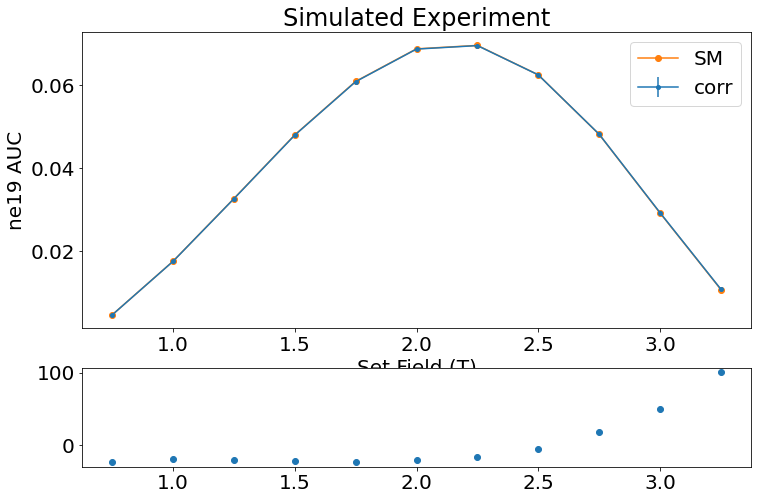

,Ne19,He6,Ratio,sRatio,Ne19_corr,sNe19_corr
set_field,,,,,,
0.75,0.000248,0.000098,2.531432,0.000316,0.004663,5.820556e-07
1.00,0.000664,0.000223,2.978729,0.000240,0.017578,1.416188e-06
1.25,0.001077,0.000377,2.858493,0.000178,0.032665,2.037895e-06
1.50,0.001473,0.000561,2.628653,0.000136,0.048000,2.488995e-06
1.75,0.001792,0.000764,2.345600,0.000106,0.060888,2.759137e-06
2.00,0.001968,0.000972,2.025255,0.000084,0.068750,2.839827e-06
2.25,0.001956,0.001169,1.673824,0.000066,0.069588,2.728574e-06
2.50,0.001735,0.001336,1.298059,0.000051,0.062536,2.435636e-06
2.75,0.001325,0.001459,0.908136,0.000037,0.048239,1.983931e-06


In [10]:
# Plot results.
f, (ax0, ax1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]},figsize=(12,8))

ax0.errorbar(
    ratio_corr["Ne19_corr"].index,
    ratio_corr["Ne19_corr"],
    yerr=ratio_corr["sNe19_corr"],
    label="corr",
    marker="o",
    ms=4,
)

ax0.plot(ratio_pred["Ne19"].index,ratio_pred["Ne19"], label="SM", marker="o", ms=6)

ax0.set_ylabel('ne19 AUC')
ax0.set_xlabel('Set Field (T)')
ax0.set_title(f"Simulated Experiment")
ax0.legend()

ax1.plot(ratio_corr["Ne19_corr"].index, (ratio_corr["Ne19_corr"] - ratio_pred["Ne19"])/ratio_corr["sNe19_corr"] , 
         label= f"residual", 
         marker="o", 
         ls = "None",
         ms=6)

plt.show()
# print(ratio_corr_cp, ratio_pred["Ne19"].index)

display(ratio_corr)

#### Now take the above and port it to the energy domain. 

* How to do this? We want uneven energy bins.
* we'll want something that looks like this: https://stackoverflow.com/questions/11774822/matplotlib-histogram-with-errorbars, https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html
* Ok so what we want is for the width x height to be equal to our AUC that we get above. And then we do need to scale the error as well because that's an error in the area.
* Then it would be nice for a plot like this to also contain the pdf of the beta spectrum. That would be powerful. 
* Then, the last step would be to get things working smoothly for smaller frequency bins, to show how that works in the energy domain. Would look cool I think and would be a nice way to present some real data. This is new but it's worth doing right. Get it working today and then rage on writing from there. 
* I need to put together some slides of the above findings and present to the group before I go into a lot of effort to write all this up in my thesis. Good to get that feedback first I think. 

#### Step 3: Plot it in gamma domain. 

TODO: 
* Build this into it's own module at some point. 
* Also add in residuals below. Wait on this until you're building plots for the thesis. 

In [11]:
gamma_acceptances, gamma_widths, gamma_heights, gamma_height_errs, SM_heights = ed.freq_to_energy_domain(
    set_fields, freq_BWs, ratio_corr, ratio_pred)

In [12]:
isotopes = {
"Ne19": {
    "W0": 5.339539,
    "Z": 10,
    "A": 19,
    "beta_type": "Mixed",
    "decay_type":"+" ,
    "mixing_ratio": 2.22,
    "R": 2.9,
    "bAc": 0,
    "dAc": 0,
    "Lambda": 0,
    "b": -.7204*b
},
"He6": {
    "W0": 7.859525,
    "Z": 2,
    "A": 6,
    "beta_type": "Gamow-Teller",
    "decay_type":"-" ,
    "mixing_ratio": None,
    "R": 1.6,
    "bAc": 0,
    "dAc": 0,
    "Lambda": 0,
    "b": b
}}
# Feed the info dict to the BetaSpectrum class. 
bspec = bs.BetaSpectrum(isotopes["Ne19"])

Ws = np.linspace(1.001, isotopes["Ne19"]["W0"]-.001, 300)
pdf = bspec.dNdE(Ws)

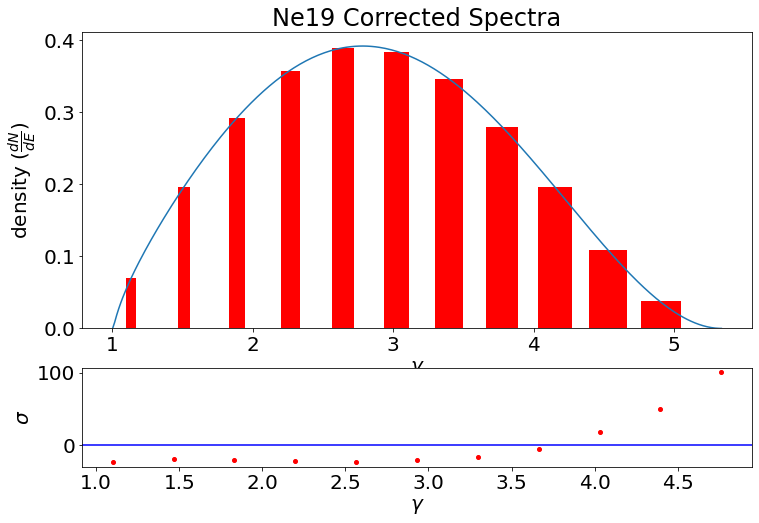

In [13]:

# fig0, ax0 = plt.subplots(figsize=(12,6))
f, (ax0, ax1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]},figsize=(12,8))


ax0.plot(Ws, pdf, label = "pdf")
ed.energy_domain_plot(ax0,ax1, gamma_acceptances, gamma_widths, gamma_heights, gamma_height_errs, SM_heights, ratio_corr, ratio_pred)        
    
plt.show()


## MC6, Thesis Section: Finer frequency bins. 

**Idea**: 

* Want to do something similar to the above but with finer frequency bins. Resulting in a plot like the above but with each chunk further chunked (lol). 

**Notes**: 

*   

**To Dos**: 

* First step is to clean up the above.  

**Questions**:
* One thing I'm not sure of is how to deal with the monitor. I guess I shouldn't reduce the monitor rate for the different chunks because it is something that is independent of the cres rate. 

### MC6, step 0: Start sloppy-ish, work towards something nice. 

In [20]:
# Select set fields. 
set_fields = np.arange(.75,3.5,.25)

# Full Freq BW.
freq_BW = np.array([18.0e9 ,  19.1e9])

C_exp = .75
b=0

# Set the frequency chunk size: 
freq_chunk = 100e6

N_per_isotope = 10**12
mon_rate = 10**12

freq_BW_tot = freq_BW[1] - freq_BW[0]
n_chunks = int(np.ceil((freq_BW_tot / freq_chunk)))
print(n_chunks)

11



Counts in chunk: 90909090909
[[Variables]]
    C:  0.82661189 +/- 6.5556e-06 (0.00%) (init = 1)
    b:  4.4441e-05 +/- 3.6983e-05 (83.22%) (init = 0)

Counts in chunk: 90909090909
[[Variables]]
    C:  0.83503960 +/- 9.3509e-06 (0.00%) (init = 1)
    b:  1.3678e-04 +/- 5.2174e-05 (38.14%) (init = 0)

Counts in chunk: 90909090909
[[Variables]]
    C:  0.84354211 +/- 4.1618e-06 (0.00%) (init = 1)
    b:  1.7147e-04 +/- 2.3000e-05 (13.41%) (init = 0)

Counts in chunk: 90909090909
[[Variables]]
    C:  0.85208853 +/- 6.5950e-06 (0.00%) (init = 1)
    b:  2.2949e-04 +/- 3.6045e-05 (15.71%) (init = 0)

Counts in chunk: 90909090909
[[Variables]]
    C:  0.86069141 +/- 7.4697e-06 (0.00%) (init = 1)
    b:  3.0156e-04 +/- 4.0406e-05 (13.40%) (init = 0)

Counts in chunk: 90909090909
[[Variables]]
    C:  0.86931775 +/- 5.9163e-06 (0.00%) (init = 1)
    b:  3.2504e-04 +/- 3.1663e-05 (9.74%) (init = 0)

Counts in chunk: 90909090909
[[Variables]]
    C:  0.87796990 +/- 6.5556e-06 (0.00%) (init = 1

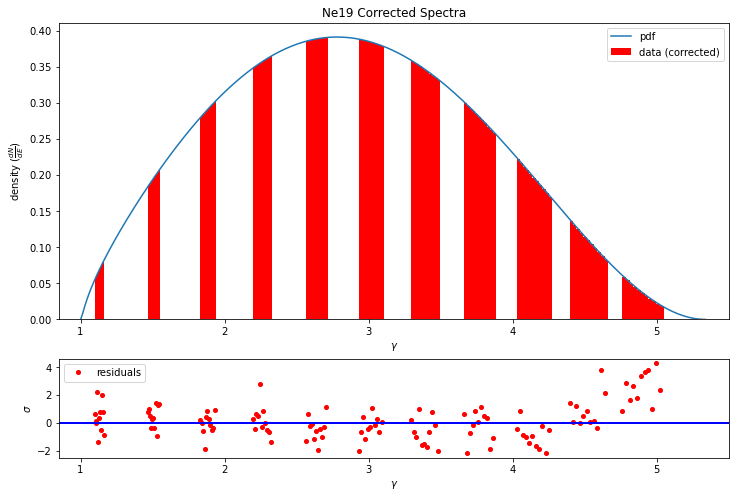

In [21]:
%matplotlib inline 
f, (ax0, ax1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]},figsize=(12,8))

b_fits = []
b_errs = []

for i,chunk in enumerate(range(n_chunks)):
    freq_BW_chunk = np.clip(np.array([freq_BW[0]+ freq_chunk*chunk, freq_BW[0]+ freq_chunk*(chunk+1)]), 0,freq_BW.max())
    freq_BW_chunk_tot = freq_BW_chunk[1] - freq_BW_chunk[0]
    N_per_isotope_in_chunk = int(N_per_isotope* freq_BW_chunk_tot/ freq_BW_tot)
    mon_rate_per_isotope_in_chunk = mon_rate
    print(f"\nCounts in chunk: {N_per_isotope_in_chunk}")
    freq_BWs = np.tile(freq_BW_chunk, (len(set_fields), 1))
    # print(freq_BWs)
    
    spectra_ne_we, spectra_he_we = we.we_simple_MC(set_fields, 
              freq_BWs, 
              C_exp, 
              b, 
              counts_per_isotope = N_per_isotope_in_chunk, 
              monitor_rate = mon_rate_per_isotope_in_chunk,                                  
              counts_pois = True,                           
              mon_pois = True,
              wall_effect = True)
    
    ratio_exp = re.build_ratio_altnorm(spectra_ne_we, spectra_he_we)
    # Conduct fit. 
    my_pars = Parameters()
    my_pars.add('C', value=1, min=-100, max = 100, vary =True)
    my_pars.add('b', value=0, min=-10, max = 10, vary =True)

    result = minimize(we.objfunc_chisq, my_pars, args = (freq_BWs, set_fields, ratio_exp))

    # Fit report.
    print(fit_report(result.params))
    
    C = result.params["C"].value
    b = result.params["b"].value

    # Get the SM prediction.
    ratio_pred = we.AUC_expectation_we(set_fields, freq_BWs, b = b, plot = False, wall_effect = False)

    ratio_corr = ratio_exp.copy()
    ratio_corr["Ne19_corr"] = C*ratio_pred["He6"]*ratio_exp["Ratio"]
    ratio_corr["sNe19_corr"] = C*ratio_pred["He6"]*ratio_exp["sRatio"]

    gamma_acceptances, gamma_widths, gamma_heights, gamma_height_errs, SM_heights = ed.freq_to_energy_domain(
    set_fields, freq_BWs, ratio_corr, ratio_pred)
    
    label_bool = i==0
    ed.energy_domain_plot(ax0,ax1, gamma_acceptances, gamma_widths, 
                          gamma_heights, gamma_height_errs, SM_heights, 
                          ratio_corr, ratio_pred, label = label_bool) 
    
    # Now add to the list of b_normed
    
    b_fits.append(result.params["b"].value)
    b_errs.append(result.params["b"].stderr)

ax0.plot(Ws, pdf, label = "pdf")


ax0.legend()
ax1.legend()

ax0.set_xlim(.85,5.5); ax1.set_xlim(.85,5.5)
plt.show()

##### Histogram the b fits. 

* Take-away: We see that the wall effect can be reduced to a 10**-4 effect with 50 MHz chunks. 

In [ ]:
f0, ax0 = plt.subplots(figsize=(12,6))
b_fits = np.array(b_fits)
b_errs = np.array(b_errs)
ax0.hist(b_fits, label = f"b_fit: mean = {b_fits.mean():.5f}", alpha = .5, color = "c")
ax0.hist(b_errs, label = f"b_err: mean = {b_errs.mean():.5f}", alpha = .5, color = "b")
ax0.legend()

plt.show()

## MC7, Thesis Section: Up from the depths. 

**Idea**: 

* Want to simulate the density of tracks coming up from below. This tells us how well our veto needs to work. 

**Notes**: 

*   In thesis illustrate how a reduction of the trap slewing to 5 ms drastically reduces this issue. 

**To Dos**: 

*  

**Braindump**: 

* What I want is the density of tracks coming up from below as a function of frequency as a function of field. Go step-wise. As this isn't that simple. Start with the 

**Questions**:
* 

### Step 0: Dumb simple model, we see everything from below. 

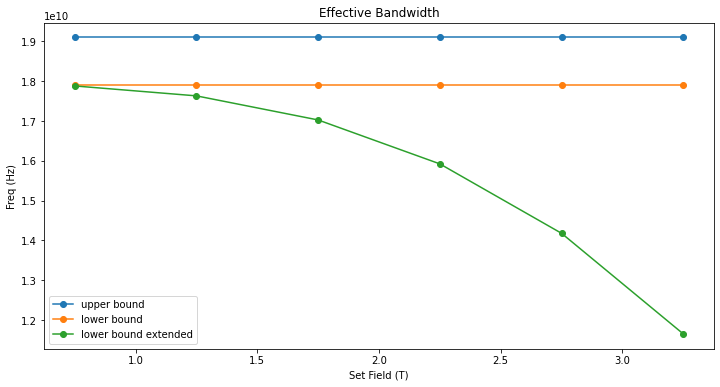

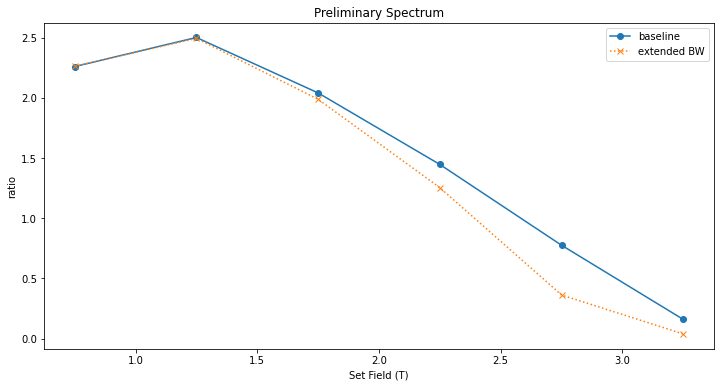

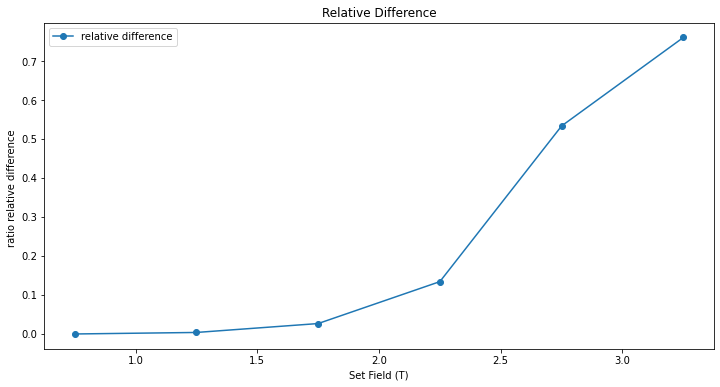

In [110]:
%matplotlib inline

# Set fields to use.
set_fields = np.arange(.75,3.5,.5)

# Freq_BW
freq_BW = np.array([17.9e9 ,  19.1e9])

# Build baseline ratio
freq_BWs_bl = np.tile(freq_BW, (len(set_fields), 1))


# Build extended BW ratio, from slope.

# Trap Slew timing. 
slew_time = 35e-3

powers = sc.power_larmor(set_fields, freq_BW.mean())
energys = sc.freq_to_energy(freq_BW.mean(), set_fields)
slopes = sc.df_dt(energys, set_fields, powers)

freq_BW_extenstion = slopes*slew_time 
freq_BWs_ext = freq_BWs_bl
freq_BWs_ext[:,0] = freq_BWs_bl[:,0] - freq_BW_extenstion

freq_BWs_bl = np.tile(freq_BW, (len(set_fields), 1))

# Plot extended BWs
fig0, ax0 = plt.subplots(figsize=(12,6))
ax0.plot(set_fields, freq_BWs_ext[:,1],  label = f"upper bound", marker='o', ms=6)
ax0.plot(set_fields, freq_BWs_bl[:,0],  label = f"lower bound", marker='o', ms=6)
ax0.plot(set_fields, freq_BWs_ext[:,0],  label = f"lower bound extended", marker='o', ms=6)
ax0.set_ylabel('Freq (Hz)')
ax0.set_xlabel('Set Field (T)')
ax0.set_title(f"Effective Bandwidth")
ax0.legend()
plt.show()

# Get expected ratios
ratio_bl = rp.AUC_expectation(set_fields, freq_BWs_bl, b = 0, plot = False)
ratio_ext = rp.AUC_expectation(set_fields, freq_BWs_ext, b = 0, plot = False)


# Plot ratios.
fig0, ax0 = plt.subplots(figsize=(12,6))

ax0.plot(ratio_bl.index, ratio_bl.Ratio,  label = f"baseline", marker='o', ms=6)
ax0.plot(ratio_ext.index, ratio_ext.Ratio,  label = f"extended BW", marker='x',ls = "dotted", ms=6)

ax0.set_ylabel('ratio')
ax0.set_xlabel('Set Field (T)')
ax0.set_title(f"Preliminary Spectrum")
ax0.legend()
plt.show()

fig0, ax0 = plt.subplots(figsize=(12,6))

ax0.plot(ratio_bl.index, (ratio_bl.Ratio - ratio_ext.Ratio) / ratio_bl.Ratio ,  label = f"relative difference", marker='o', ms=6)
# ax0.plot(ratio_ext.index, ratio_ext.Ratio,  label = f"baseline", marker='o', ms=6)

ax0.set_ylabel('ratio relative difference ')
ax0.set_xlabel('Set Field (T)')
ax0.set_title(f"Relative Difference")
ax0.legend()
plt.show()

### Display the above in the energy domain. 



In [112]:
def freq_to_energy_domain(set_fields, freq_BWs, ratio, isotope): 
    
    integrate_vect = np.vectorize(integrate.quad)

    energy_acceptances_high = sc.freq_to_energy(
        freq_BWs[:,0], set_fields
    )
    energy_acceptances_low = sc.freq_to_energy(
        freq_BWs[:,1], set_fields
    )
    energy_acceptances = np.stack((energy_acceptances_low, energy_acceptances_high), axis=-1)
    gamma_acceptances = sc.gamma(energy_acceptances)

    gamma_widths = gamma_acceptances[:,1] - gamma_acceptances[:,0]

    gamma_heights = ratio[isotope]/gamma_widths
    gamma_height_errs = ratio[isotope]/gamma_widths

    return gamma_acceptances, gamma_widths, gamma_heights

def energy_domain_plot(ax0, gamma_acceptances, gamma_widths, gamma_heights, isotope, label = "styff", color = 'r'):
 
    ax0.bar(gamma_acceptances[:,0], gamma_heights.values, width=gamma_widths,
             align = 'edge',fill = False, edgecolor = color, label = label)


    # Make plot labels and titles. 
    ax0.set_title("Spectra")
    ax0.set_xlabel(r"$\gamma$")
    # ax1.set_xlabel(r"$\gamma$")
    ax0.set_ylabel(r"density ($\frac{dN}{dE}$)")
    # ax1.set_ylabel(r"$\sigma$")
    
    return None

* Note that if you make the freq_BWs into the extendend version, then you get the extended BW, if you do bl then you get the change to the height based on naively thinking you 

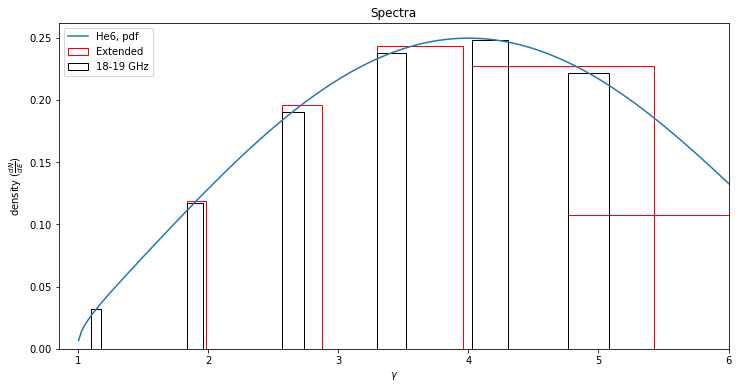

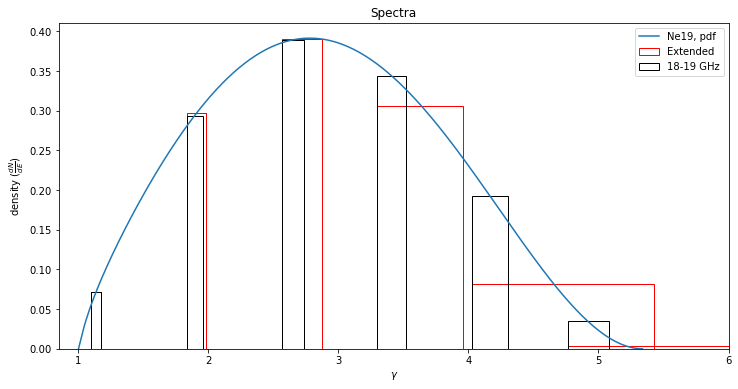

In [113]:
isotopes = ["He6", "Ne19"]
for isotope in isotopes: 
    
    fig0, ax0 = plt.subplots(figsize=(12,6))
    
    gamma_acceptances_ext, gamma_widths_ext, gamma_heights_ext = freq_to_energy_domain(
        set_fields, freq_BWs_ext, ratio_ext, isotope)

    energy_domain_plot(ax0, gamma_acceptances_ext, gamma_widths_ext, 
                       gamma_heights_ext, isotope, label = "Extended", color = 'r')
    
    gamma_acceptances_bl, gamma_widths_bl, gamma_heights_bl = freq_to_energy_domain(
    set_fields, freq_BWs_bl, ratio_bl, isotope)

    energy_domain_plot(ax0, gamma_acceptances_bl, gamma_widths_bl, 
                       gamma_heights_bl, isotope, label = "18-19 GHz", color = 'k')
    
    bspec = bs.BetaSpectrum(isotope, b = 0)

    Ws = np.linspace(1.001, bspec.W0-.001, 300)
    pdf = bspec.dNdE(Ws)
    ax0.plot(Ws, pdf, label = f"{isotope}, pdf")


    ax0.legend()


    ax0.set_xlim(.85,6)
    plt.show()

### Make a more complex event-wise monte carlo.  

* I want a function that takes a field and outputs a track candidate df (in the range of possible frequencies). 
* Only then work on vectorizing it. Which may not be that simple....

**Issues**: 
* Ok one thing to consider is that the slopes are changing as the tracks rise from below. That may not matter enough to consider for now... But it is a big deal because this means things 'from below' get to the visible part even faster than the above accounts for (these are even underestimates of the max energy that could be observed. 
* Do the below with the slope = energy of the beta when it's born vs slope of 18.0 GHz for all. See if there's a big difference. Those are the extremes. Use to justify simplification. 

### Slopes vs energy at fixed field...

* This is telling me that it's the field that matters most and not the frequency for the slope. Is this correct? I should make a plot of this... 

In [167]:
field = 3
freq = 30e9

power_larmor = sc.power_larmor(field, freq)
energy = sc.freq_to_energy(freq, field)
slope = sc.df_dt(energy, field, power_larmor)

print(power_larmor,energy, slope/1e11)

9.76392782801897e-13 919414.3432647816 1.2781266313404789


### Demo of event-wise MC:

HI: 183013420204.28214


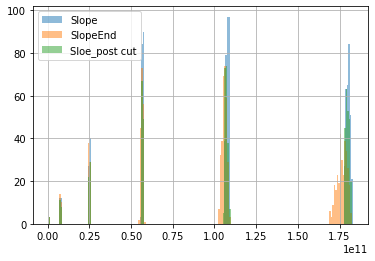

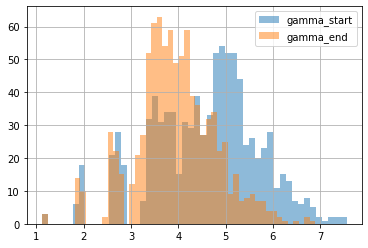

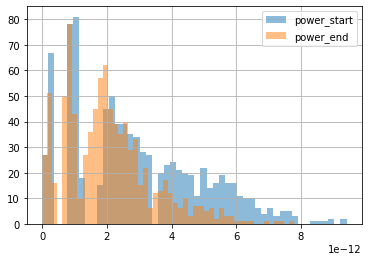

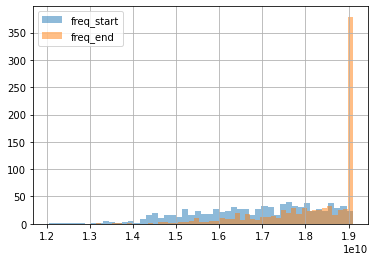

In [169]:
isotope = "He6"
# Set fields to use.
set_fields = np.arange(.75,3.5,.5)

# Hardware freq_BW
freq_BW = np.array([17.9e9 ,  19.1e9])

# Build baseline ratio
freq_BWs_generate = np.tile(freq_BW, (len(set_fields), 1))
freq_BW_visible = freq_BW

events = fb.build_canditate_events(freq_BW_visible, set_fields,  
                                isotope, cut_events = False, fix_slopes = False,
                                slew_time = .035, n = 1e3, rng_seed=12345)
events_cut = fb.cut_events_fn(events, freq_BW_visible )


events.Slope.hist(bins = 200, alpha = .5, label = "Slope")
events.SlopeEnd.hist(bins = 200, alpha = .5, label = "SlopeEnd")
events_cut.Slope.hist(bins = 200, alpha = .5, label = "Sloe_post cut")
plt.legend()
plt.show()

events.gamma_start.hist(bins = 50, alpha = .5, label = "gamma_start")
events.gamma_end.hist(bins = 50, alpha = .5, label = "gamma_end")
plt.legend()
plt.show()

events.power_start.hist(bins = 50, alpha = .5, label = "power_start")
events.power_end.hist(bins = 50, alpha = .5, label = "power_end")
plt.legend()
plt.show()

events.EventStartFreq.hist(bins = 50, alpha = .5, label = "freq_start")
events.EventEndFreq.hist(bins = 50, alpha = .5, label = "freq_end")
plt.legend()
plt.show()

2.75


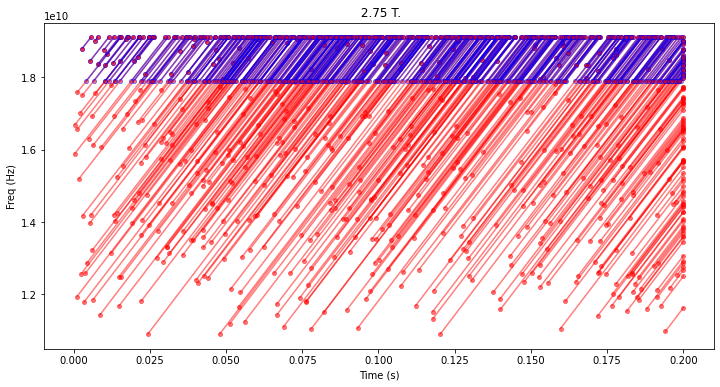

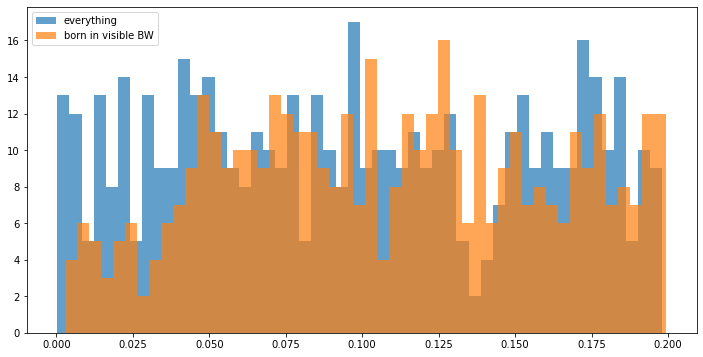

2.75


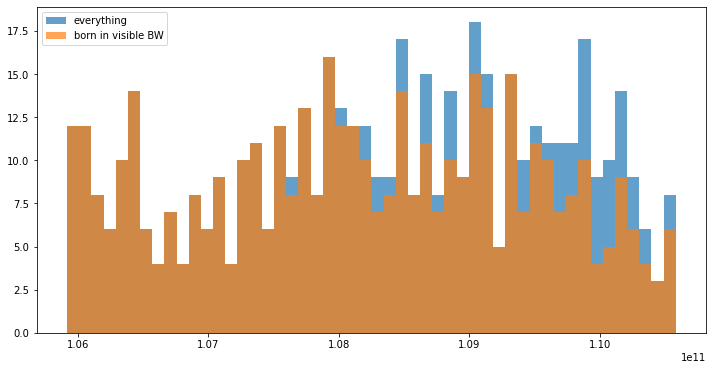

In [137]:
%matplotlib inline

for set_field in events.set_field.unique(): 
    if set_field!= 2.75: continue
    
    print(set_field)
    fig, ax = plt.subplots(figsize=(12, 6))
    fb.viz_mc_events(ax,events, set_field, color = "r")
    fb.viz_mc_events(ax,events_cut, set_field, color = "b")
    plt.show()
    
    condition = (events.set_field == set_field)
    condition_cut = (events_cut.set_field == set_field)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    

    plt.hist(events[condition].EventStartTime, bins = 50, label = "everything", alpha = .7)
    plt.hist(events_cut[condition_cut].EventStartTime, bins = 50, label = "born in visible BW", alpha = .7)

    plt.legend()
    plt.show()
    
    fig, ax = plt.subplots(figsize=(12, 6))
    print(set_field)
    condition = (events.set_field == set_field)
    condition_cut = (events_cut.set_field == set_field)
    plt.hist(events[condition].Slope, bins = 50, label = "everything", alpha = .7)
    plt.hist(events_cut[condition_cut].Slope, bins = 50, label = "born in visible BW", alpha = .7)

    plt.legend()
    plt.show()

### Next step: Make ratios. 

In [144]:
isotopes = ["Ne19", "He6"]
n_tot = 1e6
seed = 12345

# Set fields to use.
set_fields = np.arange(.75,3.5,.25)

# Hardware freq_BW
freq_BW = np.array([18.0e9 ,  19.1e9])
freq_BWs = np.tile(freq_BW, (len(set_fields), 1))

events_ne = fb.build_canditate_events(freq_BW, set_fields,  
                                isotopes[0], cut_events = True, fix_slopes = False,
                                slew_time = .005, n = n_tot, rng_seed=seed)

events_he = fb.build_canditate_events(freq_BW, set_fields,  
                                isotopes[1], cut_events = True, fix_slopes = False,
                                slew_time = .005, n = n_tot, rng_seed=seed)

[[1.79969678e+10 1.91000000e+10]
 [1.79840870e+10 1.91000000e+10]
 [1.79610319e+10 1.91000000e+10]
 [1.79252589e+10 1.91000000e+10]
 [1.78742244e+10 1.91000000e+10]
 [1.78053849e+10 1.91000000e+10]
 [1.77161967e+10 1.91000000e+10]
 [1.76041163e+10 1.91000000e+10]
 [1.74666001e+10 1.91000000e+10]
 [1.73011045e+10 1.91000000e+10]
 [1.71050859e+10 1.91000000e+10]]
HI: 179677092172.50818
[[1.79969678e+10 1.91000000e+10]
 [1.79840870e+10 1.91000000e+10]
 [1.79610319e+10 1.91000000e+10]
 [1.79252589e+10 1.91000000e+10]
 [1.78742244e+10 1.91000000e+10]
 [1.78053849e+10 1.91000000e+10]
 [1.77161967e+10 1.91000000e+10]
 [1.76041163e+10 1.91000000e+10]
 [1.74666001e+10 1.91000000e+10]
 [1.73011045e+10 1.91000000e+10]
 [1.71050859e+10 1.91000000e+10]]
HI: 179673658989.10333


In [145]:
events_he_path = "saved_ratio_dfs/events_he.csv"
events_ne_path = "saved_ratio_dfs/events_ne.csv"

In [146]:
events_he.to_csv(events_he_path)
events_ne.to_csv(events_ne_path)

KeyboardInterrupt: 

##### Read these csvs in. 

In [22]:
events_he = pd.read_csv(events_he_path)
events_ne = pd.read_csv(events_ne_path)

#### Simulate an experiment with events coming from below

In [147]:
cuts = {"EventStartFreq": (17.9e9, 19.1e9),
        "set_field": (1.25,np.inf)}

spectra_ne_exp, spectra_he_exp = fb.build_MC_spectra(events_ne, events_he, cuts, monitor_rate = 10**8)

display(spectra_he_exp)

# Build the experimental ratio.
ratio_exp = re.build_ratio_altnorm(spectra_ne_exp, spectra_he_exp)

display(ratio_exp)

,set_field,event_count,tot_monitor_rate
0,1.25,12999,100015541
1,1.50,22132,100001835
2,1.75,32306,99992185
3,2.00,42409,100012099
4,2.25,54750,99995793
5,2.50,67031,99996657
6,2.75,77393,100000126
7,3.00,86268,100001856
8,3.25,90566,99999166


,Ne19,He6,Ratio,sRatio
set_field,,,,
1.25,0.000333,0.000130,2.559085,0.026471
1.50,0.000503,0.000221,2.271305,0.018322
1.75,0.000643,0.000323,1.989316,0.013568
2.00,0.000752,0.000424,1.772614,0.010766
2.25,0.000796,0.000548,1.453856,0.008072
2.50,0.000730,0.000670,1.088983,0.005825
2.75,0.000584,0.000774,0.754054,0.004134
3.00,0.000358,0.000863,0.415548,0.002611
3.25,0.000119,0.000906,0.131425,0.001281


,Ne19,He6,Ratio,sRatio
set_field,,,,
1.25,0.000333,0.000130,2.559085,0.026471
1.50,0.000503,0.000221,2.271305,0.018322
1.75,0.000643,0.000323,1.989316,0.013568
2.00,0.000752,0.000424,1.772614,0.010766
2.25,0.000796,0.000548,1.453856,0.008072
2.50,0.000730,0.000670,1.088983,0.005825
2.75,0.000584,0.000774,0.754054,0.004134
3.00,0.000358,0.000863,0.415548,0.002611
3.25,0.000119,0.000906,0.131425,0.001281


[[Variables]]
    C:  1.04231597 +/- 0.02132766 (2.05%) (init = 1)
    b:  0 (fixed)


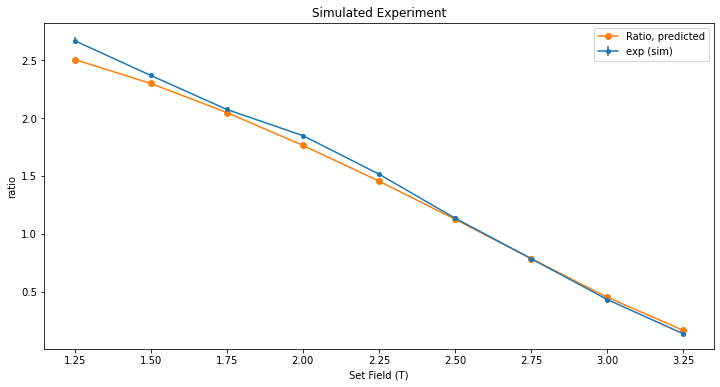

In [148]:
# Set fields to use.
set_fields = np.arange(1.25,3.5,.25)
# Hardware freq_BW
freq_BW = np.array([18.0e9 ,  19.1e9])
freq_BWs = np.tile(freq_BW, (len(set_fields), 1))

b = 0
ratio_pred = rp.AUC_expectation(set_fields, freq_BWs, b = b, plot = False)

# Conduct fit. 
my_pars = Parameters()
my_pars.add('C', value=1, min=0, max = 10, vary =True)
my_pars.add('b', value=0, min=-10, max = 10, vary =False)

display(ratio_exp)
result = minimize(mc.objfunc_chisq, my_pars, args = (freq_BWs, set_fields, ratio_exp))

# Fit report.
print(fit_report(result.params))

# Plot results.
fig0, ax0 = plt.subplots(figsize=(12,6))

C = result.params["C"].value

ratio_exp_cp = ratio_exp.copy()
ratio_exp_cp["Ratio"] = C*ratio_exp_cp["Ratio"]
ratio_exp_cp["sRatio"] = C*ratio_exp_cp["sRatio"]

pm.plot_experimental_ratio(ratio_exp_cp, ax0, label= f"exp (sim)")
pm.plot_predicted_ratio(ratio_pred, ax0)

# ax0.set_yscale("log")
ax0.set_ylabel('ratio')
ax0.set_xlabel('Set Field (T)')
ax0.set_title(f"Simulated Experiment")
ax0.legend()
plt.show()

### Work on a plot comparing the amount coming from below to the amount born in the visible BW: 

* Change the below to 18.001 once you have enough stats. 


,set_field,event_count,tot_monitor_rate
0,1.25,12999,100015541
1,1.50,22132,100001835
2,1.75,32306,99992185
3,2.00,42409,100012099
4,2.25,54750,99995793
5,2.50,67031,99996657
6,2.75,77393,100000126
7,3.00,86268,100001856
8,3.25,90566,99999166


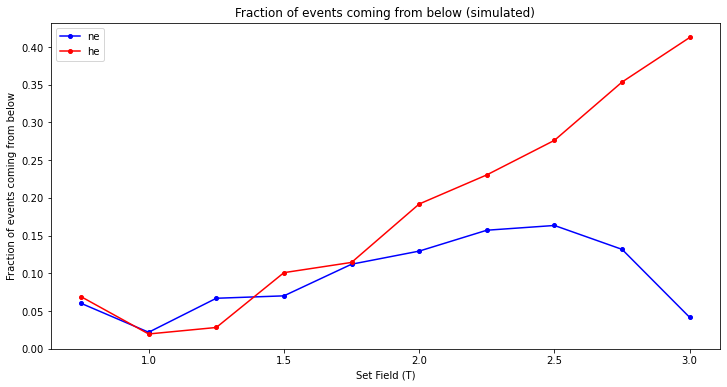

In [153]:
set_fields = np.arange(.75,3.5,.25)

below_cut = {"EventStartFreq": (17.99e9, 18.0001e9)}
within_cut = {"EventStartFreq": (18.001e9, 19.1e9)}

spectra_ne_below, spectra_he_below = fb.build_MC_spectra(events_ne, events_he, below_cut, monitor_rate = 10**5)
spectra_ne_within, spectra_he_within = fb.build_MC_spectra(events_ne, events_he, within_cut, monitor_rate = 10**5)

display(spectra_he_exp)

ne_from_below  = (spectra_ne_below / spectra_ne_within).event_count.values
he_from_below  = (spectra_he_below / spectra_he_within).event_count.values

# Plot results.
fig0, ax0 = plt.subplots(figsize=(12,6))

plt.plot(set_fields, ne_from_below, marker="o",
        ms=4, color = "b", label = "ne") 
plt.plot(set_fields, he_from_below, marker="o",
        ms=4, color = "r", label = "he") 

# ax0.set_yscale("log")
ax0.set_ylabel('Fraction of events coming from below')
ax0.set_xlabel('Set Field (T)')
ax0.set_title(f"Fraction of events coming from below (simulated)")
ax0.legend()
plt.show()

# OLD (DELETE ONCE DONE WITH THIS STUFF)

In [7]:
isotope_name = "He6"
# Set fields to use.
set_fields = np.arange(.75,3.5,.5)

# Hardware freq_BW
freq_BW = np.array([17.9e9 ,  19.1e9])

# Build baseline ratio
freq_BWs = np.tile(freq_BW, (len(set_fields), 1))

powers = sc.power_larmor(set_fields, freq_BW.mean())
energys = sc.freq_to_energy(freq_BW.min(), set_fields)
slopes = sc.df_dt(energys, set_fields, powers)

freq_BW_extenstion = slopes*slew_time 
freq_BWs_ext = freq_BWs_bl
freq_BWs_ext[:,0] = freq_BWs_bl[:,0] - freq_BW_extenstion

freq_BWs_bl = np.tile(freq_BW, (len(set_fields), 1))

print(freq_BWs_ext)

integrate_vect = np.vectorize(integrate.quad)

energy_acceptances_high = sc.freq_to_energy(
    freq_BWs_ext[:,0], set_fields
)
energy_acceptances_low = sc.freq_to_energy(
    freq_BWs_ext[:,1], set_fields
)
energy_acceptances = np.stack((energy_acceptances_low, energy_acceptances_high), axis=-1)
gamma_acceptances = sc.gamma(energy_acceptances)

# Build extended BW ratio, from slope.
# Trap Slew timing. 
slew_time = 35e-3
delta_W = 0
W_low = sc.gamma(energy_acceptances[:, 0]) + delta_W
W_high = sc.gamma(energy_acceptances[:, 1]) - delta_W

# Feed the info dict to the BetaSpectrum class.
bspec = bs.BetaSpectrum(isotope_name, b = 0 )

fraction_of_spectrum, err = integrate_vect(
    bspec.dNdE,
    W_low,
    W_high,
)

print(gamma_acceptances)

[[1.78832348e+10 1.91000000e+10]
 [1.76498064e+10 1.91000000e+10]
 [1.70830008e+10 1.91000000e+10]
 [1.60494668e+10 1.91000000e+10]
 [1.44158536e+10 1.91000000e+10]
 [1.20488103e+10 1.91000000e+10]]
[[1.09918154 1.17396923]
 [1.83196923 1.98249269]
 [2.56475693 2.86757918]
 [3.29754462 3.9243112 ]
 [4.03033231 5.33990906]
 [4.76312    7.55058717]]


#### How to randomly sample from the pdf??

(array([380., 270., 177.,  88.,  48.,  22.,   9.,   5.,   0.,   1.]),
 array([0.        , 0.29029029, 0.58058058, 0.87087087, 1.16116116,
        1.45145145, 1.74174174, 2.03203203, 2.32232232, 2.61261261,
        2.9029029 ]),
 <BarContainer object of 10 artists>)

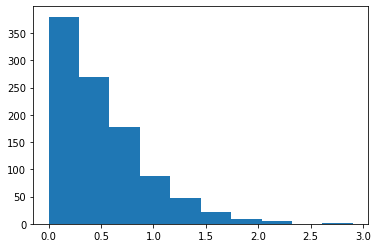

In [8]:
import scipy
x = np.linspace(0, 100, 1000)
fit_pdf = scipy.stats.norm.pdf(x, -1,1)


samples = np.random.choice(x, size=1000, p=fit_pdf/np.sum(fit_pdf)) 

plt.hist(samples)

[4.10620805 4.85621412 6.07040078 ... 3.71291219 4.53608958 2.21061345]


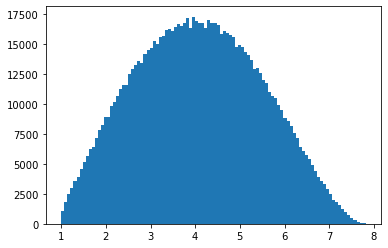

In [9]:
# The following works. 
bspec = bs.BetaSpectrum(isotope_name, b = 0 )
Ws = np.linspace(1.001, bspec.W0-.001, 3000)
pdf = bspec.dNdE(Ws)
samples = np.random.choice(Ws, size=int(1e6), p=pdf/np.sum(pdf)) 
plt.hist(samples, bins = 100)
print(samples)

### After Breakfast: 

* Work on making the density plots. Keep things neat, then move on to making ratios just as you would for real data (with the fit to C), you got this. keep b fixed at 0. 

In [77]:
def build_canditate_events(freq_BW_visible, set_fields,  
                           isotope, cut_events = True, n = 1e3, slew_time = .035,
                           fix_slopes = True, rng_seed=12345) -> pd.DataFrame:
    
    # Make number of events to simulate an int. 
    n = int(n)
    
    # Initialize rng with given seed for repeatability
    rng = np.random.default_rng(rng_seed)
    
    # Feed the info dict to the BetaSpectrum class.
    bspec = bs.BetaSpectrum(isotope, b = 0 )
    Ws = np.linspace(1.00, bspec.W0, 1000)
    pdf = bspec.dNdE(Ws)
    
    # Sample n gammas from full pdf.
    gammas = np.random.choice(Ws, size=n, p=pdf/pdf.sum()) 
    
    # Generate expanded BW
    freq_BWs_generate = build_extended_freqBW(freq_BW_visible, set_fields, slew_time)
    
    print(freq_BWs_generate.shape)
    print(set_fields.shape)
    energy_acceptances_high = sc.freq_to_energy(
        freq_BWs_generate[:,0], set_fields
    )
    energy_acceptances_low = sc.freq_to_energy(
        freq_BWs_generate[:,1], set_fields
    )
    energy_acceptances = np.stack((energy_acceptances_low, energy_acceptances_high), axis=-1)
    gamma_acceptances = sc.gamma(energy_acceptances)
    
    # Build events dict.
    events = {}
    events["set_field"] = []
    events["gamma_start"] = [] 

       
    # Figure out how to vectorize this if it has performance issues. Otherwise, fine. 
    for index, (gamma_acceptance, field) in enumerate(zip(gamma_acceptances,set_fields)): 

        gamma_field = gammas[np.logical_and(gammas>=gamma_acceptance[0], gammas<=gamma_acceptance[1])]
        field_field = np.array([field]*len(gamma_field))

        events["set_field"].append(field_field)
        events["gamma_start"].append(gamma_field)

    events["set_field"] = np.concatenate(events["set_field"])
    events["gamma_start"] = np.concatenate(events["gamma_start"])
    
    
    events = pd.DataFrame(events)
    
    # Select start times uniformly in the observation/slew window. 
    events["EventStartTime"] = rng.uniform(0, slew_time, size = len(events["set_field"]))
    events["EventStartFreq"] = sc.energy_to_freq(sc.energy(events["gamma_start"]), events["set_field"])
    events["energy_start"] = sc.energy(events["gamma_start"])
    
    

    # for key, val in events.items(): 
    #     print(key)
    #     print(f"{key}:{val.shape}")
    
    
    
    # Trying to make slopes work faster. 
    # events["Slope"] = get_slope(events["set_field"], events["energy_start"], freq_BW_visible)
    
    
    events["EventEndTime"] = slew_time
    events["TimeLength"] = events["EventEndTime"] - events["EventStartTime"]
    
    # Trying to make slopes work faster.
    events = get_slope_info(events, freq_BW_visible, fix_slopes = fix_slopes)
    
#     events = events.apply(lambda row: df_dt_naive(row), axis='columns', result_type='expand')

#     events["SlopeStart"] = sc.df_dt(events["energy_start"], events["set_field"], events["power_start"])
    
#     events["SlopeEnd"] = sc.df_dt(events["energy_end"], events["set_field"], events["power_end"])
#     events["gamma_end"] = sc.gamma(events["energy_end"])
#     events["EventEndFreq"] = sc.energy_to_freq(sc.energy(events["gamma_end"]), events["set_field"])
#     events["TimeLength"] = events["EventEndTime"] - events["EventStartTime"]
#     events["FreqLength"] = events["EventEndFreq"] - events["EventStartFreq"]
#     # This is a bit sloppy but won't matter much
#     events["Slope"] = (events["SlopeStart"] + events["SlopeEnd"]) /2 
#     events["Slope"] = events["FreqLength"] / events["TimeLength"]
    if cut_events: 
        events = cut_events_fn(events, freq_BW_visible )

    return events

def cut_events_fn(events, freq_BW_visible ):
    
    events["EventEndFreq"] = np.minimum(events["EventEndFreq"], freq_BW_visible[1])
    
    events["EventEndTime"] = np.minimum(events["EventEndTime"],
                                        events["EventStartTime"] + (freq_BW_visible[1] -events["EventStartFreq"])/events["Slope"])
    
    cut_condition = (events["EventEndFreq"] < freq_BW_visible[0]) 
    events= events.copy()[~cut_condition]
    
    # Note that the order of the below two operations is crucial for it to work. 
    events["EventStartTime"] = np.maximum(events["EventStartTime"],
                            events["EventStartTime"] + 
                                          (freq_BW_visible[0] -events["EventStartFreq"])/events["Slope"])
    events["EventStartFreq"] = np.maximum(events["EventStartFreq"], freq_BW_visible[0])
    
    # Recalculate things now. Should I make different names??  
    events["TimeLength"] = events["EventEndTime"] - events["EventStartTime"]
    events["FreqLength"] = events["EventEndFreq"] - events["EventStartFreq"]
    
    return events
           
               
def build_extended_freqBW(freq_BW_visible, set_fields, slew_time): 
    """Note that this should integrate backwards technically... 
    But this should be approximately correct."""

    powers = sc.power_larmor(set_fields, freq_BW_visible.min())
    energys = sc.freq_to_energy(freq_BW_visible.min(), set_fields)
    slopes = sc.df_dt(energys, set_fields, powers)

    freq_BW_extenstion = slopes*slew_time
    
    freq_BWs = np.tile(freq_BW_visible, (len(set_fields), 1))
    freq_BWs[:,0] = freq_BWs[:,0] - freq_BW_extenstion
    
    return freq_BWs


### The way I'm dealing with the slope is wrong or at least janky. Need to fix. 

In [78]:
def get_slope_info(events, freq_BW_visible, fix_slopes = True): 
    
    if fix_slopes:
        # Fix slope to be the max slope within the visible BW. 
        power_larmor = sc.power_larmor(events["set_field"], freq_BW_visible.min())
        energy_fixed = sc.freq_to_energy(freq_BW_visible.min(), events["set_field"])
        # print(power_larmor.shape)
        events["power_start"] = power_larmor
        events["Slope"] = sc.df_dt(energy_fixed, events["set_field"], events["power_start"])
    else: 
        # Fix slope to be the slope it's born with (could be larger or smaller than the above). 
        power_larmor = sc.power_larmor_e(events["set_field"], events["energy_start"])
        print("HIII",power_larmor.shape)
        events["power_start"] = power_larmor
        events["Slope"] = sc.df_dt(events["energy_start"], events["set_field"], events["power_start"])
    
    # events["power_start"] = power_larmor

    
    
    
    
    
    events["energy_end"] = events["energy_start"] - power_larmor*events["TimeLength"]*sc.J_TO_EV
    events["gamma_end"] = sc.gamma(events["energy_end"])
    
    events["power_end"] = sc.power_larmor_e(events["set_field"], events["energy_end"])
    events["SlopeEnd"] = sc.df_dt(events["energy_end"], events["set_field"], events["power_end"])
    
    events["EventEndFreq"] = events["EventStartFreq"] + events["TimeLength"]* events["Slope"]
    
    # sc.energy_to_freq(sc.energy(events["gamma_end"]), events["set_field"])
    # events["TimeLength"] = events["EventEndTime"] - events["EventStartTime"]
    events["FreqLength"] = events["EventEndFreq"] - events["EventStartFreq"]
    
    return events

def df_dt_naive(events_row): 

    energy = events_row["energy_start"]
    power = sc.power_larmor_e(events_row["set_field"], energy)
    events_row["power_start"] = power
    energy -= power*events_row["TimeLength"]*sc.J_TO_EV
    power = sc.power_larmor_e(events_row["set_field"], energy)
    events_row["energy_end"] = energy
    events_row["power_end"] = power
    
    return events_row

def df_dt_naive_alt(events_row): 
    dt = .005
    if events_row["TimeLength"]<=dt: 
        energy = events_row["energy_start"]
        power = sc.power_larmor_e(events_row["set_field"], energy)
        events_row["power_start"] = power
        energy -= power*events_row["TimeLength"]*sc.J_TO_EV
        power = sc.power_larmor_e(events_row["set_field"], energy)
        events_row["energy_end"] = energy
        events_row["power_end"] = power
        return events_row
    
    else: 
        ts = np.arange(0, events_row["TimeLength"], dt)
        # print(ts)

        energy = events_row["energy_start"]
        power = sc.power_larmor_e(events_row["set_field"], energy)
        events_row["power_start"] = power
        for t in ts: 

            energy -= power*dt*sc.J_TO_EV
            power = sc.power_larmor_e(events_row["set_field"], energy)

        events_row["energy_end"] = energy
        events_row["power_end"] = power

        return events_row
          


#### TO DO: 
* Get a different function to do the cutting. Just keep the first function the full tracks so you can keep things neat. You got this. 

In [111]:
# Feed the info dict to the BetaSpectrum class.
bspec = bs.BetaSpectrum("Ne19", b = 0 )

integrate_vect = np.vectorize(integrate.quad)
fraction_of_spectrum, err = integrate_vect(
    bspec.dNdE,
    0,
    15)

print(fraction_of_spectrum)

1.000000005625803


In [13]:
def we_simple_MC(set_fields, 
              freq_BWs, 
              C_exp, 
              b, 
              counts_per_isotope = 10**4, 
              monitor_rate = 10**5,                                  
              counts_pois = True,                           
              mon_pois = True,
              wall_effect = True): 
    
    # Simulate data.
    ratio_pred = we.AUC_expectation_we(set_fields, freq_BWs, b = b, plot = False, wall_effect = wall_effect)

    # Simulate data that provides the "spectra" df for both ne and he.
    spectra_ne_exp = pd.DataFrame()
    spectra_he_exp = pd.DataFrame()

    spectra_ne_exp["set_field"] = ratio_pred.index
    spectra_he_exp["set_field"] = ratio_pred.index

    spectra_ne_exp.index = ratio_pred.index
    spectra_he_exp.index = ratio_pred.index

    spectra_ne_exp["event_count"] = ratio_pred["Ne19"]*counts_per_isotope/ratio_pred["Ne19"].sum()
    spectra_he_exp["event_count"] = ratio_pred["He6"]*counts_per_isotope/ratio_pred["He6"].sum()

    spectra_ne_exp["tot_monitor_rate"] = C_exp*monitor_rate
    spectra_he_exp["tot_monitor_rate"] = monitor_rate
    
    if mon_pois:
        # Apply a poisson statistic with the given mean for the event counts. 
        spectra_ne_exp["tot_monitor_rate"] = np.random.poisson(spectra_ne_exp["tot_monitor_rate"])
        spectra_he_exp["tot_monitor_rate"] = np.random.poisson(spectra_he_exp["tot_monitor_rate"])
    
    if counts_pois:
        # Apply a poisson statistic with the given mean for the event counts.  
        spectra_ne_exp["event_count"] = np.random.poisson(spectra_ne_exp["event_count"])
        spectra_he_exp["event_count"] = np.random.poisson(spectra_he_exp["event_count"])

    # ratio_exp = re.build_ratio_altnorm(spectra_ne_exp, spectra_he_exp)
    
    return spectra_ne_exp, spectra_he_exp

In [73]:
# Select set fields. 
set_fields = np.arange(.75,3.5,.25)
# Freq BW.
freq_BW = np.array([19.0e9 ,  19.1e9])
# Tile freq_BW.
freq_BWs = np.tile(freq_BW, (len(set_fields), 1))

# C, relationship between he and ne monitor.
C_exp = np.random.uniform(.25,1.75)

# monitor rate tot: 
mon = 10**10
# Set little b.
b = 0

b_uncert = {}
for exp in np.linspace(3,12):
    # Number of counts: 
    N = 10**exp
    
    b_uncert[exp] = []
    
    for trial in range(20): 
        print(f"N = 10**{exp}, trial = {trial}")
        
        # Simulate simple experiment. Don't poisson vary monitor.
        ratio_exp, spectra_ne_exp, spectra_he_exp = mc.simple_MC(set_fields, 
                                                                 freq_BWs, 
                                                                 C_exp, 
                                                                 b, 
                                                                 counts_per_isotope = N, 
                                                                 monitor_rate = mon,
                                                                 counts_pois = True, 
                                                                 mon_pois = False)

        ratio_pred = rp.AUC_expectation(set_fields, freq_BWs, b = b, plot = False)

        # Conduct fit. 
        my_pars = Parameters()
        my_pars.add('C', value=1, min=0, max = 10, vary =True)
        my_pars.add('b', value=.001, min=-10, max = 10, vary =True)

        result = minimize(mc.objfunc_chisq, my_pars, args = (freq_BWs, set_fields, ratio_exp, b))
        
        b_uncert[exp].append(result.params["b"].stderr)

b_uncert = pd.DataFrame(b_uncert)

N = 10**3, trial = 0
N = 10**3, trial = 1
N = 10**3, trial = 2
N = 10**3, trial = 3
N = 10**3, trial = 4
N = 10**3, trial = 5
N = 10**3, trial = 6
N = 10**3, trial = 7
N = 10**3, trial = 8
N = 10**3, trial = 9
N = 10**3, trial = 10
N = 10**3, trial = 11
N = 10**3, trial = 12
N = 10**3, trial = 13
N = 10**3, trial = 14
N = 10**3, trial = 15
N = 10**3, trial = 16
N = 10**3, trial = 17
N = 10**3, trial = 18
N = 10**3, trial = 19
N = 10**4, trial = 0
N = 10**4, trial = 1
N = 10**4, trial = 2
N = 10**4, trial = 3
N = 10**4, trial = 4
N = 10**4, trial = 5
N = 10**4, trial = 6
N = 10**4, trial = 7
N = 10**4, trial = 8
N = 10**4, trial = 9
N = 10**4, trial = 10
N = 10**4, trial = 11
N = 10**4, trial = 12
N = 10**4, trial = 13
N = 10**4, trial = 14
N = 10**4, trial = 15
N = 10**4, trial = 16
N = 10**4, trial = 17
N = 10**4, trial = 18
N = 10**4, trial = 19
N = 10**5, trial = 0
N = 10**5, trial = 1
N = 10**5, trial = 2
N = 10**5, trial = 3
N = 10**5, trial = 4
N = 10**5, trial = 5
N = 10**5, tri

          3         4         5         6         7         8         9   \
0   0.123282  0.095392  0.025262  0.005739  0.002900  0.000610  0.000269   
1   0.308715  0.047387  0.027104  0.005869  0.001725  0.000740  0.000356   
2   0.227528  0.067832  0.017769  0.007746  0.003266  0.000787  0.000258   
3   0.254086  0.054840  0.023621  0.009934  0.002694  0.000904  0.000274   
4   0.190093  0.042385  0.023312  0.004753  0.002529  0.000686  0.000249   
5   0.218580  0.061290  0.018763  0.007846  0.002562  0.000555  0.000152   
6   0.348392  0.095815  0.026292  0.005587  0.002047  0.000955  0.000186   
7   0.229896  0.073416  0.024777  0.009044  0.002790  0.000566  0.000294   
8   0.196279  0.076745  0.009003  0.005995  0.001826  0.000579  0.000224   
9   0.167900  0.072855  0.017263  0.010531  0.002561  0.000878  0.000104   
10  0.201541  0.056542  0.029468  0.009599  0.001966  0.000835  0.000231   
11  0.173684  0.097489  0.026816  0.006909  0.002394  0.000837  0.000231   
12  0.191100

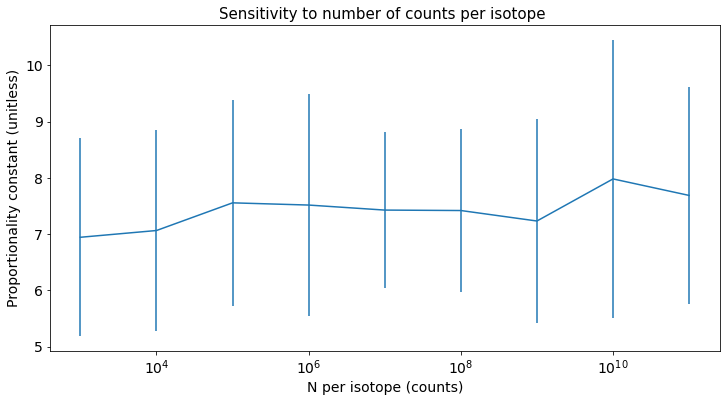

In [87]:
%matplotlib inline

# Plot results.
fig0, ax0 = plt.subplots(figsize=(12,6))
print(b_uncert)
N = 10**b_uncert.mean().index.values
print(b_uncert.mean().values)
Const = b_uncert.mean().values * np.sqrt(N)
Const_err = b_uncert.std().values * np.sqrt(N)
plt.errorbar(N, Const, yerr =  Const_err)

ax0.set_xscale("log")
ax0.set_ylabel('Proportionality constant (unitless)')
ax0.set_xlabel('N per isotope (counts)')
ax0.set_title(f"Sensitivity to number of counts per isotope ")


# ------ Set Thesis Plot Parameters -----------

params = {
    "axes.titlesize": 15,
    "legend.fontsize": 14,
    "axes.labelsize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
}
plt.rcParams.update(params)
figsize = (10,6)

# Save the figure.
figures_path = Path("/home/drew/He6CRES/rocks_analysis_notebooks/saved_plots")
plt.savefig(figures_path / Path(f"Const_prop.png"), bbox_inches="tight", dpi=300)
plt.show()




In [29]:
# Select set fields. 
set_fields = np.arange(1.25,3.5,.25)

# Freq BW.
freq_BW = np.array([17.9e9 ,  19.1e9])
freq_BWs = np.tile(freq_BW, (len(set_fields), 1))

C_exp = np.random.uniform(.25,.7)
print(C_exp)

# Simulate real data.
b = .2
ratio_pred = rp.AUC_expectation(set_fields, freq_BWs, b = b, plot = False)

ratio_pred["Ratio"] 
# display(ratio_pred)

# Simulate data that provides the "spectra" df for both ne and he. You got this. 
# This way you can test out how everything works from the beginning. 

counts_per_isotope = 10**4
monitor_rate = 10**5

spectra_ne_exp = pd.DataFrame()
spectra_he_exp = pd.DataFrame()

spectra_ne_exp["set_field"] = ratio_pred.index
spectra_he_exp["set_field"] = ratio_pred.index

spectra_ne_exp.index = ratio_pred.index
spectra_he_exp.index = ratio_pred.index

spectra_ne_exp["event_count"] = ratio_pred["Ne19"]*counts_per_isotope/ratio_pred["Ne19"].sum()
spectra_he_exp["event_count"] = ratio_pred["He6"]*counts_per_isotope/ratio_pred["He6"].sum()

spectra_ne_exp["tot_monitor_rate"] = C_exp*monitor_rate
spectra_he_exp["tot_monitor_rate"] = monitor_rate

# Apply a poisson statistic with the given mean.  
spectra_ne_exp["event_count"] = np.random.poisson(spectra_ne_exp["event_count"])
spectra_he_exp["event_count"] = np.random.poisson(spectra_he_exp["event_count"])

display(spectra_ne_exp)
display(spectra_he_exp)

ratio_exp = re.build_ratio_altnorm(spectra_ne_exp, spectra_he_exp)

display(ratio_exp)

0.4262151947002324


,set_field,event_count,tot_monitor_rate
set_fields,,,
1.25,1.25,762,42621.51947
1.50,1.50,1165,42621.51947
1.75,1.75,1330,42621.51947
2.00,2.00,1613,42621.51947
2.25,2.25,1679,42621.51947
2.50,2.50,1471,42621.51947
2.75,2.75,1118,42621.51947
3.00,3.00,689,42621.51947
3.25,3.25,256,42621.51947


,set_field,event_count,tot_monitor_rate
set_fields,,,
1.25,1.25,352,100000
1.50,1.50,573,100000
1.75,1.75,758,100000
2.00,2.00,997,100000
2.25,2.25,1284,100000
2.50,2.50,1397,100000
2.75,2.75,1580,100000
3.00,3.00,1552,100000
3.25,3.25,1587,100000


,Ne19,He6,Ratio,sRatio
set_field,,,,
1.25,0.017878,0.00352,5.079060,0.327323
1.50,0.027334,0.00573,4.770264,0.243404
1.75,0.031205,0.00758,4.116741,0.187352
2.00,0.037845,0.00997,3.795861,0.152921
2.25,0.039393,0.01284,3.068010,0.113740
2.50,0.034513,0.01397,2.470514,0.092294
2.75,0.026231,0.01580,1.660182,0.064882
3.00,0.016166,0.01552,1.041594,0.047683
3.25,0.006006,0.01587,0.378472,0.025491


In [8]:
# Fit to the free normalization parameter. 
def objfunc_chisq(my_pars, freq_BWs, ratio_exp): 

    C =my_pars["C"].value
    b =my_pars["b"].value
    # print(C,b)

    ratio_pred = rp.AUC_expectation(set_fields, freq_BWs, b = b, plot = False)
    # I think the lmfit does the least squares on these values for you but double check. 
    chisq_gauss = (ratio_pred["Ratio"] - C*ratio_exp["Ratio"])/ (C*ratio_exp["sRatio"])
    # print(chisq_gauss)
    return chisq_gauss